# Convolutional Neural Networks

## Write an Algorithm for Landmark Classification

In [1]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

'grep' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
from src.helpers import setup_env

# This will download dataset
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


### Notes about the dataset transformations

Using PyTorchs transform module with the Compose class, several transforms can be listed and performed consecutively. The images are first resized so that the smaller edge of the image will be 256px. This will greatly downsize the images in the dataset to enable faster training on limited compute. After resizing, the images are then square cropped to 224px x 224px dimensions. The cropping is in a random location for the train dataset and center cropped for the validation and test datasets. I chose 224px as the final crop size because many of pytorchs pretrained models are trained and designed to work with 224px dimensions.

The train dataset is then augmented first with a RandomHorizontalFlip and then RandAugment augmentations. RandAugment is set to apply 2 random natural image augmentations in sequence with a magnitude of 9. The magnitude decides how drastic each of the random augmentations are. These augmentations will help the model learn more features in each training picture as if the one image was in fact several images due to the augmentations. This should improve the models accuracy and help prevent overfitting.

### Visualize a Batch of Training Data

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


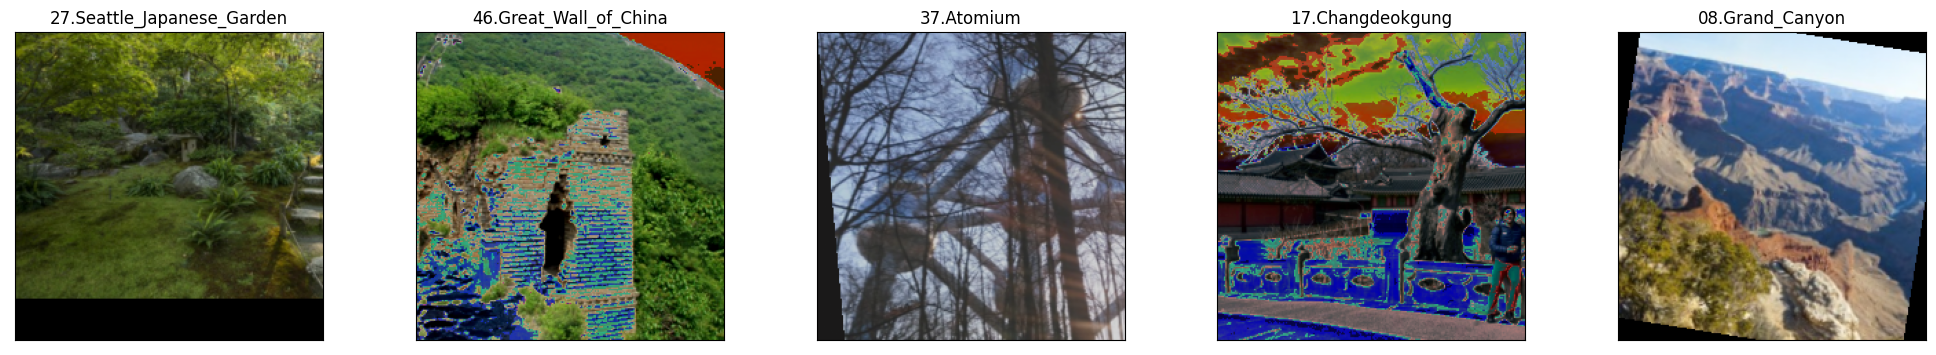

In [5]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary
data_loaders = get_data_loaders(batch_size=5, valid_size=0.01, num_workers=-1)

visualize_one_batch(data_loaders)

## Define a Model

### Notes about Model Architecture

The model architecture consists of 4 blocks in the backbone and 2 fully connected layers in the head. Each block in the convolutional section consists of either 2 or 3 Convolution layers each followed by Batch Normalization layers and ReLU activation units. The last layer in the block is a MaxPooling layer which downsizes the pixel resolution by half. The consecutive convolutional layers mostly double the channel count/feature maps though there are some convolutional layers with the same consecutive channels to refine the feature maps in those channels further. With this backbone architecture the model will be able to learn many features in the images from more basic structures in the earlier convolutional layers to more abstract and intricate structures in the deeper convolutional layers. 

I chose a kernel size of 3 and a padding of 1 for all the convolutional layers. This will allow the model to discern local features and also allow a downize by exactly 1/2 in each max pooling layer. There are 4 max pooling layers that downsize the image from 224x224 px to a final resolution of 14x14px. The max pooling layers allow the model to get rid of noise and keep the important features, increase the size of the models receptive field and also helps with translation invariance in regards to the features.

Batch Normalization layers are incorporated after the Convolutional Layers in order to make the model train more stably and allow for faster convergence. Batch Normalization also decreases the models sensitivity to initialization weights and has a small regularization effect.

After the last Max Pooling layer, the feature maps are stacked and flattened and two Linear layers with Batch Normalization, ReLU activation units and Dropout are added. The last layer of the model is a Linear layer with outputs equal to the number of classes in the dataset. This last layer ouputs the logits for each class. A softmax layer will need to be added during prediction to output probabilities of the classes.

## Training the Model

In [1]:
## Hyperparameters

batch_size = 64        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 50        # number of epochs for training
num_classes = 50       # number of classes. Do not change this
dropout = 0.25          # dropout for our model
learning_rate = 0.003  # Learning rate for SGD (or Adam)
opt = 'sgd'            # optimizer. 'sgd' or 'adam'
weight_decay = 0     # regularization. Increase this to combat overfitting

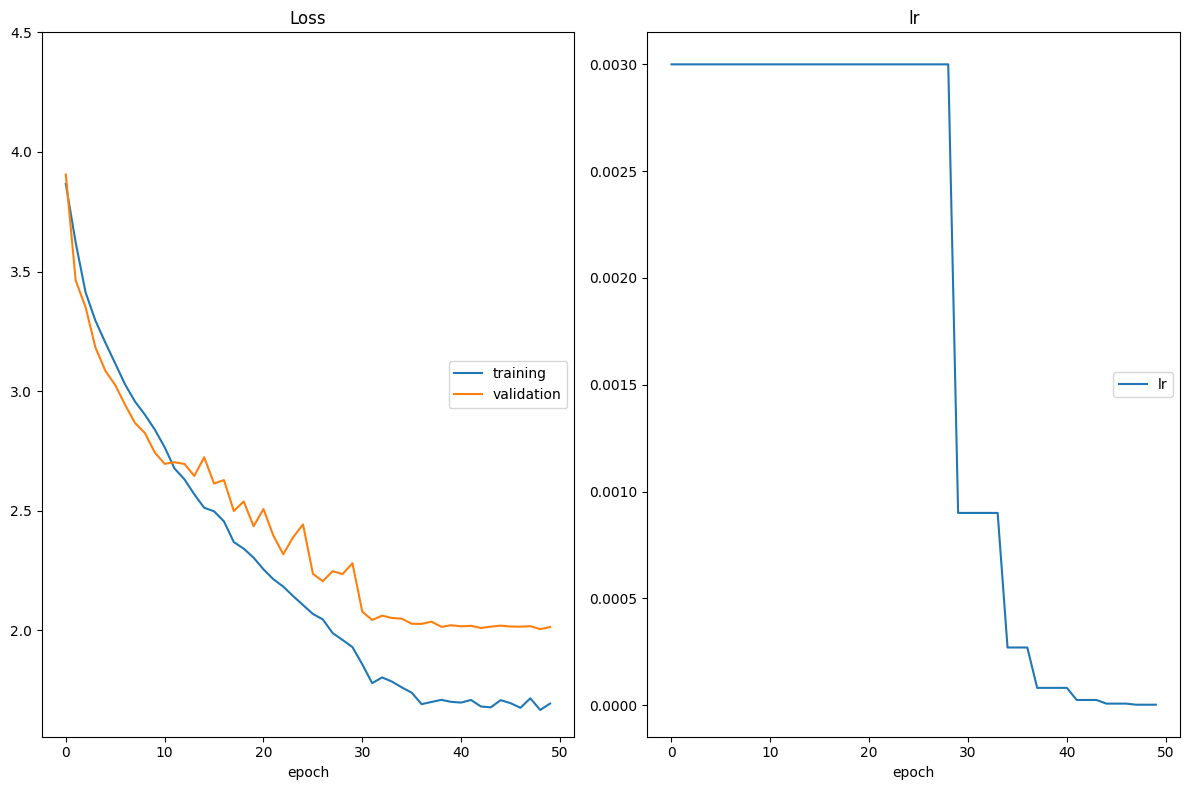

In [3]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel

# get the data loaders using batch_size and valid_size defined in the previous cell
data_loaders = get_data_loaders(batch_size=batch_size, valid_size=valid_size)

# instance model MyModel with num_classes and drouput defined in the previous cell
model = MyModel(num_classes=num_classes, dropout=dropout)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(
    model=model, optimizer=opt, learning_rate=learning_rate, weight_decay=weight_decay
)

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True,
)

## Testing the Model

In [6]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

model.load_state_dict(torch.load("checkpoints/best_val_loss.pt"))
# Run test
one_epoch_test(data_loaders["test"], model, loss)

Testing: 100%|██████████████████████████████████| 20/20 [00:02<00:00,  7.42it/s]

Test Loss: 1.870130


Test Accuracy: 53% (663/1250)


1.870130330324173

## Export using torchscript

In [8]:
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training

# YOUR CODE HERE
model.load_state_dict(torch.load("checkpoints/best_val_loss.pt", map_location="cpu"))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2697, 0.2706, 0.3017])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [9]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/original_exported.pt")

In [10]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

100%|███████████████████████████████████████| 1250/1250 [02:02<00:00, 10.24it/s]

Accuracy: 0.5144


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

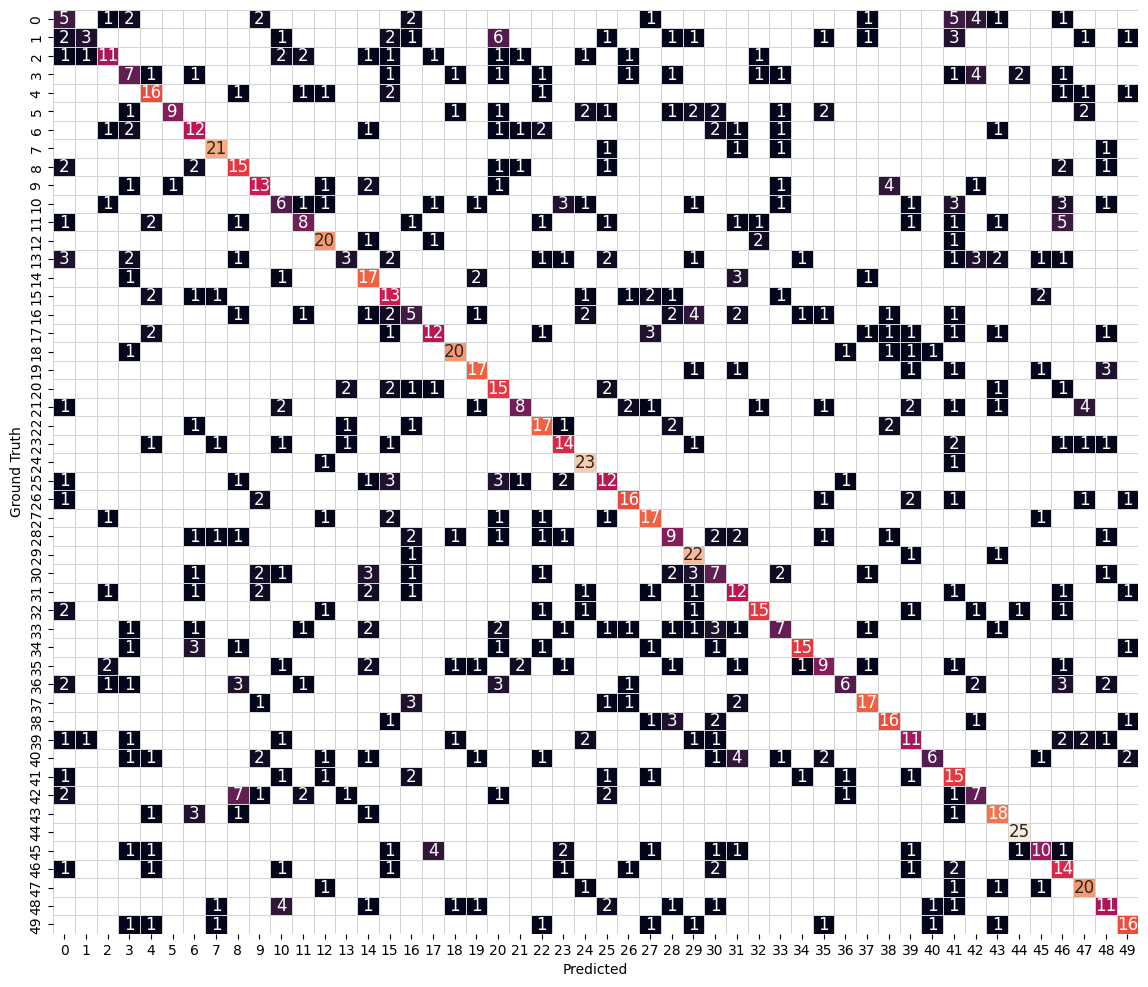

In [11]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)